In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Show dataframe values with commas
pd.options.display.float_format = '{:,.0f}'.format

In [2]:
# Load data
df = pd.read_excel('data/AC2021_AnnualisedEntryExit.xlsx', sheet_name="Annualised", skiprows = 5, header = [0,1])

# Initial data cleaning
df.columns = [' '.join(col).strip() for col in df.columns.values]
df.columns = df.columns.str.replace('Unnamed: \d+_level_0 ', '', regex=True)

# Final data cleaning using the six dimensions of data quality: 
# 0. relevance, 1. accuracy, 2. completeness, 3. uniqueness, 4. consistency, 5. timeliness, 6. validity  
df = (
    df[df['Mode'] == 'LU'] 
    .dropna() 
    .drop_duplicates() 
    .assign(**{col: df[col].astype('float') for col in df.columns[6:]}) # keeping this as a float for now, for formatting purposes
    .assign(**{df.columns[1]: df[df.columns[1]].astype(str)})
)

In [3]:
df.head()

,Mode,NLC,ASC,Station,Coverage,Source,Weekday (Mon-Thu) Entries,Friday Entries,Saturday Entries,Sunday Entries,Weekday (Mon-Thu) Exits,Friday Exits,Saturday Exits,Sunday Exits,Annualised En/Ex
0,LU,500,ACTu,Acton Town,Station entry / exit,Gateline,"6,851","6,899","5,657","3,961","6,886","6,691","5,559","4,174","2,902,697"
1,LU,502,ALDu,Aldgate,Station entry / exit,Gateline,"8,038","6,690","5,035","3,585","9,655","8,611","7,453","4,594","3,525,128"
2,LU,503,ALEu,Aldgate East,Station entry / exit,Gateline,"12,751","13,270","13,617","9,980","11,984","12,882","12,951","8,261","5,611,130"
3,LU,505,ALPu,Alperton,Station entry / exit,Gateline,"3,109","3,121","2,543","1,654","3,347","3,325","2,537","1,732","1,345,253"
4,LU,506,AMEu,Amersham,Station entry / exit,Gateline,"2,384","2,249","1,745","1,089","2,315","2,175","1,545","1,063","946,577"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 0 to 269
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Mode                       269 non-null    object 
 1   NLC                        269 non-null    object 
 2   ASC                        269 non-null    object 
 3   Station                    269 non-null    object 
 4   Coverage                   269 non-null    object 
 5   Source                     269 non-null    object 
 6   Weekday (Mon-Thu) Entries  269 non-null    float64
 7   Friday Entries             269 non-null    float64
 8   Saturday Entries           269 non-null    float64
 9   Sunday Entries             269 non-null    float64
 10  Weekday (Mon-Thu) Exits    269 non-null    float64
 11  Friday Exits               269 non-null    float64
 12  Saturday Exits             269 non-null    float64
 13  Sunday Exits               269 non-null    float64

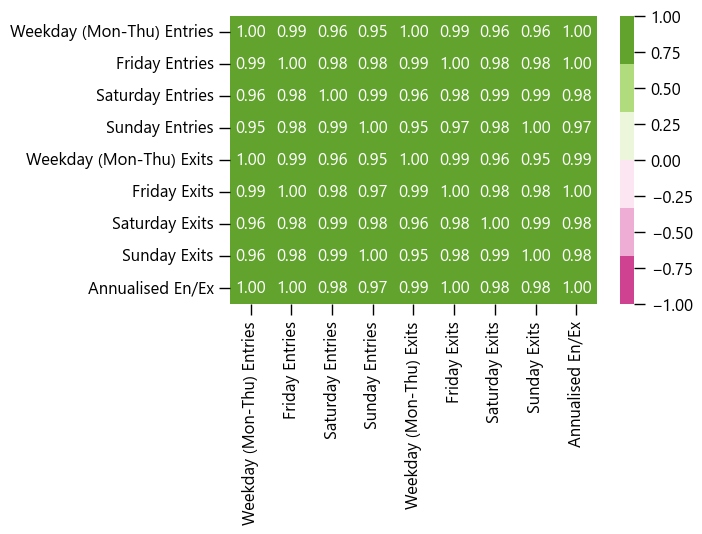

In [21]:
# creating a colormap
colormap = sns.color_palette("PiYG")

# Create sns heatmap of df.corr(), setting annot=True and fmt=".2f" and numeric_only
# vmap between -1 and 1
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap=colormap, vmin=-1, vmax=1);

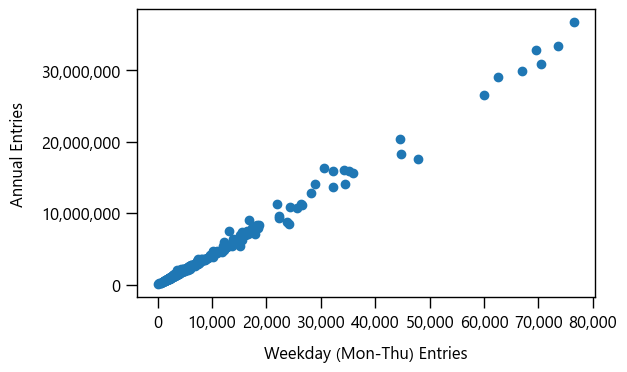

In [6]:
X = df['Weekday (Mon-Thu) Entries'] # Capital X because we may have more than one feature
y = df['Annualised En/Ex'] # y is the target variable, annual entries in millions

plt.scatter(X, y)
plt.xlabel('Weekday (Mon-Thu) Entries')
plt.ylabel('Annual Entries')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))) # Show commas on both axes
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))) # Show commas on both axes
plt.show()

In [7]:
# Use curve_fit to find the best fit line
from scipy.optimize import curve_fit

def equation_of_a_line(x, slope, intercept):
    # y = mx + c
    return slope*x + intercept

popt, pcov = curve_fit(equation_of_a_line, X, y)

In [8]:
slope = popt[0]
intercept = popt[1]
error_in_slope = np.sqrt(np.diag(pcov)[0])
error_in_intercept = np.sqrt(np.diag(pcov)[1])

print(f'slope = {int(slope):,}')
print(f'error_in_slope = {int(error_in_slope):,}')
print(f'intercept = {int(intercept):,}')
print(f'error_in_intercept = {int(error_in_intercept):,}')

slope = 452
error_in_slope = 2
intercept = -188,174
error_in_intercept = 39,992


In [9]:
# The intercept is the y-intercept, the point where the line crosses the y-axis
# However, the intercept is negative, which is not possible
# So let us think of this as an indicator of the quality of the fit

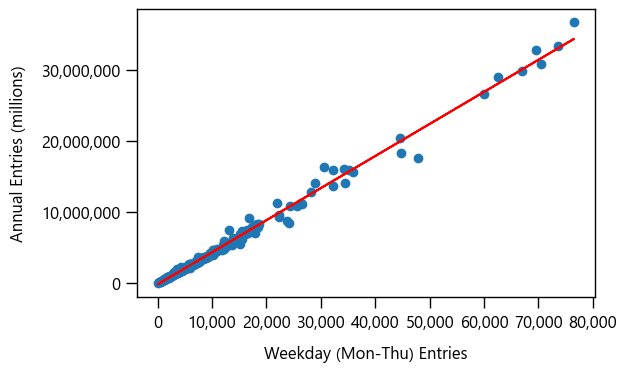

In [10]:
# Plot the data and the fitted model
plt.scatter(X, y)
plt.plot(X, equation_of_a_line(X, *popt), color='red')
plt.xlabel('Weekday (Mon-Thu) Entries')
plt.ylabel('Annual Entries (millions)')
# Show commas on x-axis
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

In [11]:
# We can now use the equation for the line of best fit 
# to predict the annual entries for any value of Friday entries
print(f'{int(equation_of_a_line(x=20_000, slope=slope, intercept=intercept)):,}')
print(f'{int(equation_of_a_line(x=50_000, slope=slope, intercept=intercept)):,}')

8,854,229
22,417,837


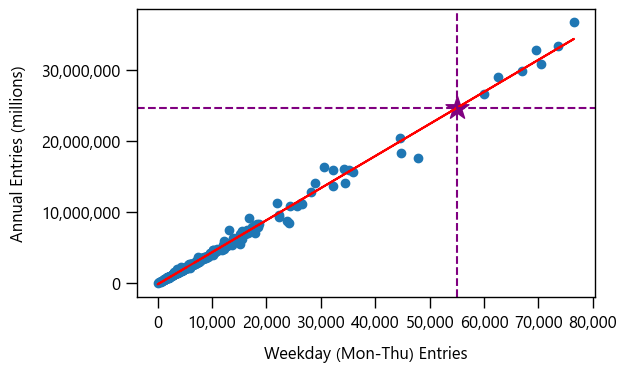

In [12]:
x_predicted = 55_000
y_predicted = equation_of_a_line(x_predicted, slope, intercept)

plt.scatter(X, y)
plt.plot(X, equation_of_a_line(X, *popt), color='red')
plt.xlabel('Weekday (Mon-Thu) Entries')
plt.ylabel('Annual Entries (millions)')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.scatter(x_predicted, y_predicted, color='purple', marker='*', s=300)
plt.axhline(y_predicted, color='purple', linestyle='--')
plt.axvline(x_predicted, color='purple', linestyle='--')
plt.show()

slope = 444
error_in_slope = 2
24,464,292


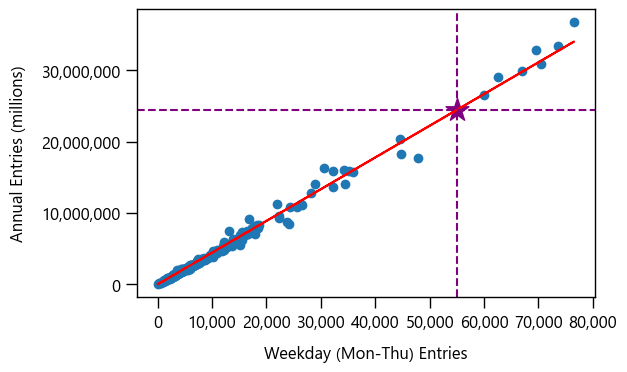

In [13]:
# Use curve_fit to find the best fit line
from scipy.optimize import curve_fit

def equation_of_a_line(x, slope):
    # y = mx 
    # Setting intercept to 0
    return slope*x 

popt, pcov = curve_fit(equation_of_a_line, X, y)

slope = popt[0]
error_in_slope = np.sqrt(np.diag(pcov)[0])

print(f'slope = {int(slope):,}')
print(f'error_in_slope = {int(error_in_slope):,}')

x_predicted = 55_000
y_predicted = equation_of_a_line(x_predicted, slope)
print(f'{int(y_predicted):,}')
plt.scatter(X, y)
plt.plot(X, equation_of_a_line(X, *popt), color='red')
plt.xlabel('Weekday (Mon-Thu) Entries')
plt.ylabel('Annual Entries (millions)')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.scatter(x_predicted, y_predicted, color='purple', marker='*', s=300)
plt.axhline(y_predicted, color='purple', linestyle='--')
plt.axvline(x_predicted, color='purple', linestyle='--')
plt.show()

In [14]:
# Perform a linear regression on the data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=4)

# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train.values.reshape(-1, 1), y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test.values.reshape(-1, 1))

# The coefficients
print('Slope: \n', regr.coef_[0])

# Print the intercept
print('Intercept: \n', regr.intercept_)

Slope: 
 455.3424512003281
Intercept: 
 -207804.1715241354


In [16]:
# The root mean squared error using f-strings
print(f'Root mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred)):,.2f}')

Root mean squared error: 621,892.07


In [17]:
# The coefficient of determination: 1 is perfect prediction
print(f'Coefficient of determination: {r2_score(y_test, y_pred):,.3f}')

Coefficient of determination: 0.988


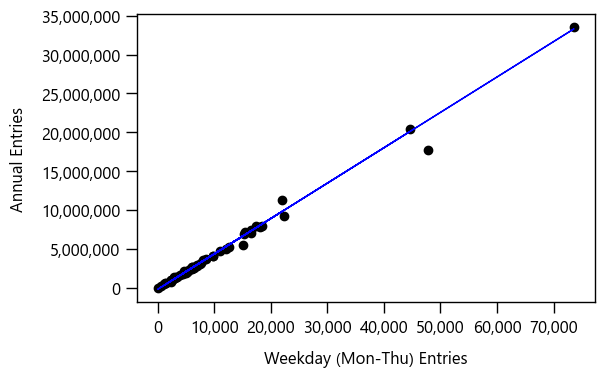

In [18]:
# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=1)
plt.xlabel('Weekday (Mon-Thu) Entries')
plt.ylabel('Annual Entries')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.show()

In [19]:
to_predict = 55_000
prediction = regr.predict(np.array([to_predict]).reshape(-1, 1))
print(f'Predicted Annual Entries for {to_predict} Friday Entries: {int(prediction[0]):,}')

Predicted Annual Entries for 55000 Friday Entries: 24,836,030


Slope without intercept: 
 447.2668170779539
Slope with intercept: 
 455.3424512003281
Intercept: 
 -207804.1715241354
Root mean squared error without intercept: 622753.64
Root mean squared error with intercept: 621892.07
Coefficient of determination without intercept: 0.988
Coefficient of determination with intercept: 0.988


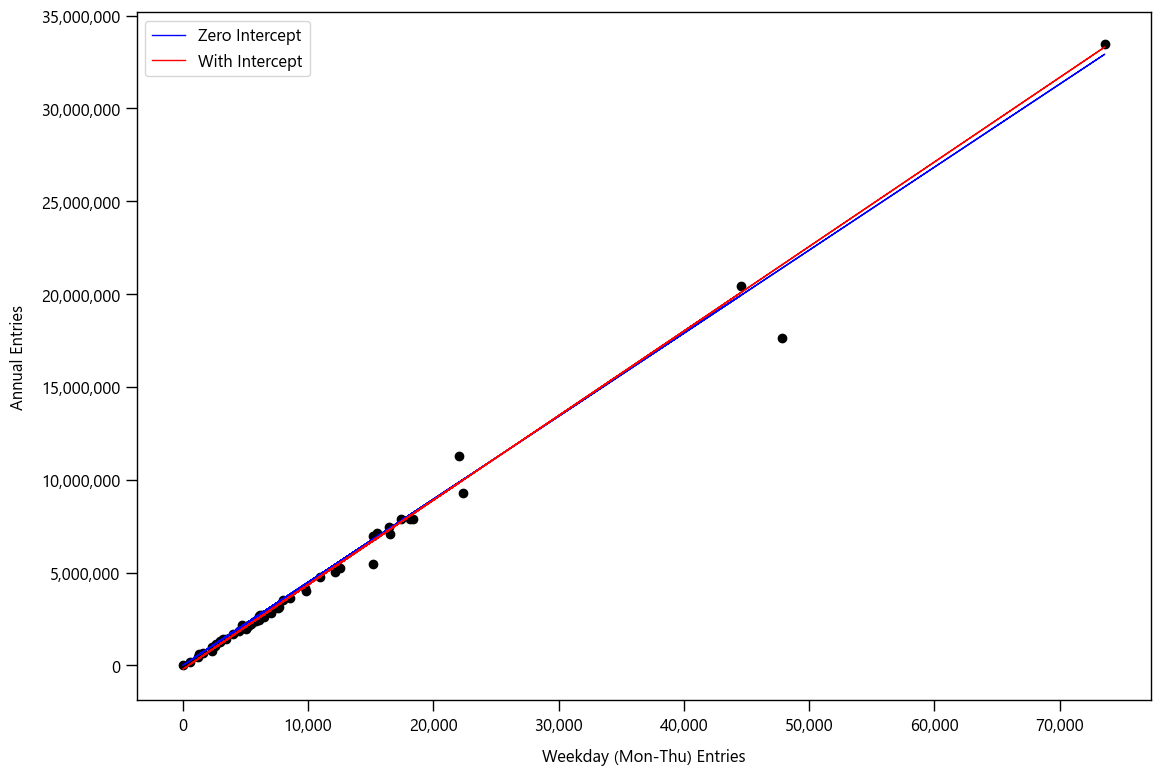

In [20]:
# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=4)

# Create linear regression object
regr_without_intercept = LinearRegression(fit_intercept=False)
regr_with_intercept = LinearRegression(fit_intercept=True)

# Train the model using the training sets
regr_without_intercept.fit(X_train.values.reshape(-1, 1), y_train)
regr_with_intercept.fit(X_train.values.reshape(-1, 1), y_train)

# Make predictions using the testing set
y_pred_without = regr_without_intercept.predict(X_test.values.reshape(-1, 1))
y_pred_with = regr_with_intercept.predict(X_test.values.reshape(-1, 1))

# The coefficients
print('Slope without intercept: \n', regr_without_intercept.coef_[0])
print('Slope with intercept: \n', regr_with_intercept.coef_[0])

# Print the intercept
#print('Intercept without intercept: \n', regr_without_intercept.intercept_)
print('Intercept: \n', regr_with_intercept.intercept_)

# The root mean squared error using f-strings
print(f'Root mean squared error without intercept: {np.sqrt(mean_squared_error(y_test, y_pred_without)):.2f}')
print(f'Root mean squared error with intercept: {np.sqrt(mean_squared_error(y_test, y_pred_with)):.2f}')

# The coefficient of determination: 1 is perfect prediction
print(f'Coefficient of determination without intercept: {r2_score(y_test, y_pred_without):.3f}')
print(f'Coefficient of determination with intercept: {r2_score(y_test, y_pred_with):.3f}')

# Plot outputs
plt.figure(figsize=(12, 8))
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred_without, color='blue', linewidth=1, label='Zero Intercept')
plt.plot(X_test, y_pred_with, color='red', linewidth=1, label='With Intercept')
plt.xlabel('Weekday (Mon-Thu) Entries')
plt.ylabel('Annual Entries')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.legend()
plt.show()
